In [2]:
import keras
import tensorflow as tf
import pandas as pd
import sklearn
import json
import numpy as np
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, LSTM, Dense, Flatten, LeakyReLU
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# PREPROCESSING THE DATASET

data = pd.read_excel('/content/gdrive/My Drive/training_set_rel3.xls')

maxForSet = [12, 6, 3, 3, 4, 4, 30, 60]
# NORMALIZING THE ESSAY GRADES TO 0 - 1
for essay_set in range(1,9):
    starter = (data['essay_set'] == essay_set).idxmax()
    if(essay_set!=8):
        end = (data['essay_set'] == essay_set+1).idxmax()
    else:
        end = 12978
    for i in range(starter, end):
      data.at[i,'domain1_score'] = data['domain1_score'][i]/maxForSet[essay_set-1]

In [0]:
# SANITIZING THE DATA
test = data
test.replace(' ', np.nan, inplace=True)
test = test.dropna(subset=['domain1_score'])
test['domain1_score'].isnull().values.any()
data = test
data.head(10)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,0.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,"Dear @LOCATION1, I think that computers have a...",4.0,4.0,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,Did you know that more and more people these d...,5.0,5.0,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,@PERCENT1 of people agree that computers make ...,5.0,5.0,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",4.0,5.0,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1,In the @LOCATION1 we have the technology of a ...,5.0,4.0,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data=data[data['essay_set']==1]

In [0]:
def convert_to_sentences(essay, remove_stopwords):
  tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
  sentences = tokenizer.tokenize(essay)
  print(sentences)
  sentences_as_wordlists = []
  for sentence in sentences:
      if len(sentence) > 0:
          sentences_as_wordlists.append(convert_to_wordlist(sentence, remove_stopwords))
  return sentences_as_wordlists


def convert_to_wordlist(essay, remove_stopwords):
  essay = re.sub("[^a-zA-Z]", " ", essay)
  word_list = essay.lower().split()
  if remove_stopwords:
    list_of_stopwords = stopwords.words("english")
    word_list_stopfree = []
    for word in word_list:
      if word not in list_of_stopwords:
        word_list_stopfree.append(word)
  return word_list_stopfree

def avg_feature_vecs(essays, model, num_features):
  essays_feature_vecs = np.zeros((len(essays),num_features),dtype="float32")
  index2word_set = model.wv.index2word
  counter = 0
  for essay in essays:
    feature_vec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    for word in essay:
      if word in index2word_set:
        num_words += 1
        feature_vec = np.add(feature_vec,model[word])
    feature_vec = np.divide(feature_vec,num_words)
    essays_feature_vecs[counter] = feature_vec
    counter = counter + 1
  return essays_feature_vecs

In [0]:
train_essays = data['essay']
score = data['domain1_score']

sentences = []
for essay in train_essays:
            sentences += convert_to_sentences(essay, remove_stopwords = True)

In [0]:
!pip install sumy

In [0]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.nlp.tokenizers import Tokenizer

listOfSummaries = []
for essay in train_essays:
  parser = PlaintextParser.from_string(essay, Tokenizer("english"))
  summarizer = LexRankSummarizer()
  summary = summarizer(parser.document, 4)
  s = ''
  for sentence in summary:
    s += ' ' + str(sentence)
  listOfSummaries.append(s)

In [0]:
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10

model_words = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context)
clean_train_essays = []
for essay in train_essays:
  clean_train_essays.append(convert_to_wordlist(essay, remove_stopwords=True))
trainDataVecs = avg_feature_vecs(clean_train_essays, model_words, num_features)

trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
trainDataVecs.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(1783, 1, 300)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(trainDataVecs, score, 
                                                    test_size=0.2)

In [0]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape = [1,300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [0]:
# ONLY FOR GRAPH. DO NOT RUN OTHERWISE
# TRAINING
KAPPA_COHEN_SCORES = []
for i in range(0,50):
  lstm_model = get_model()
  history = lstm_model.fit(X_train, y_train, batch_size=256, epochs=i, validation_data=[X_test,y_test], verbose = 1)
  y_pred = lstm_model.predict(trainDataVecs)
  # score
  y_pred = y_pred * 100
  y_pred = np.around(y_pred)
  kappa_score = score
  kappa_score = kappa_score * 100
  kappa_score = np.around(kappa_score)
  result = cohen_kappa_score(kappa_score,y_pred,weights='quadratic')
  KAPPA_COHEN_SCORES.append(result)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 10381 samples, valid

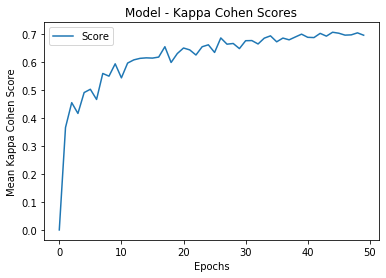

In [0]:
KAPPA_COHEN_SCORES
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# plt.plot(history.history['mean_absolute_error'])
# plt.plot(history.history['val_mean_absolute_error'])
plt.plot(KAPPA_COHEN_SCORES)
plt.title('Model - Kappa Cohen Scores')
plt.ylabel('Mean Kappa Cohen Score')
plt.xlabel('Epochs')
plt.legend(['Score'], loc='upper left')
plt.savefig("myfig.png", dpi=300)
plt.show()
# history.history

In [0]:
# TRAINING
lstm_model = get_model()
history = lstm_model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=[X_test,y_test], verbose = 1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1426 samples, valida

In [0]:
y_pred = lstm_model.predict(trainDataVecs)
# score
y_pred = y_pred * 100
y_pred = np.around(y_pred)
kappa_score = score
kappa_score = kappa_score * 100
kappa_score = np.around(kappa_score)
result = cohen_kappa_score(kappa_score,y_pred,weights='quadratic')
print("Kappa Score:", result)

Kappa Score: 0.5644201258658694


In [0]:
# Prediction
num_essay = 6
proto_essay = data['essay'][num_essay]
proto_score = data['domain1_score'][num_essay]
predict_essay = []
predict_essay.append(essay_to_wordlist(proto_essay, remove_stopwords=True))
hello = getAvgFeatureVecs(predict_essay, model_words, num_features)
hello = np.reshape(hello, (hello.shape[0], 1, hello.shape[1]))
hello.shape
print("Actual score:",proto_score)
print("Predicted score:",lstm_model.predict(hello)[0][0])

Actual score: 0.8333333333333334
Predicted score: 0.78438145


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


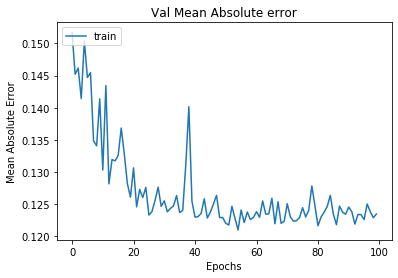

In [0]:
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Val Mean Absolute error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train'], loc='upper left')
plt.savefig("just_val.png", dpi=300)
# plt.show()
# history.history